In [16]:
import numpy as np
import pandas as pd
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ztest as ztest


# Оглавление

1. [Создание DF](#first-bullet)
2. [Дополнение DF](#second-bullet)
3. [Исследование DF](#third-bullet)
4. [Кластеризация](#cluster)
5. [AB-test](#ab-test)

## 1. Создание DF <a class="anchor" id="first-bullet"></a>

•	Дата-фрейм будет состоять из 10000 строк и 5 колонок.
Каждую из колонок мы предлагаем тебе создать и наполнить далее.

1-я колонка - user_id. Длина user_id должна равняться 15-ти символам и состоять из случайной комбинации следующих символов: "1234567890abcdefghijk". Комбинации каждого id в df формируются рандомно.


2-я колонка - номер заказа. Случайные значения лежат в диапазоне от 1 до 10.


3-я колонка - время доставки. Значения берутся из нормального распределения со средним 1440 и стандартным отклонением в 200.


4-я колонка - общая стоимость заказа. Значения берутся из экспоненциального распределения с параметром лямбда = 1, смещённого на +1.


5-я колонка - ретеншен - день жизни покупателя, в который он совершил заказ. Сгенерировать значения 1,2,3,4,5 с соответствующими вероятностями 0.35, 0.25, 0.2, 0.15, 0.05.

В случае дублей user_id, оставьте только первую из дублирующихся записей.



In [2]:
##чтобы получать "одинаковые" случайные числа
np.random.seed(42)
df_rows = 10000 ##кол-во строк

In [3]:
## 1.user_id с повтором символов
simbols=list('1234567890abcdefghijk')

user_id=[]
for i in range(df_rows):
    user_id.append(''.join(np.random.choice(simbols)  for i in range(15))) 

#### если имелась ввиду генерация без повтора символов:  
#user_id2=[]
#for i in range(10):
    #np.random.shuffle(simbols)
    #user_id2.append(''.join(simbols[:15]))

##2. 
order_num = np.random.randint(1,11,size=df_rows)
#3.
delivery_time=np.round(np.random.normal(1440, 200, df_rows)  , 2)

##4.
order_cost=np.round(np.random.exponential(1, df_rows) + 1, 2)

## 5. 
retention = np.random.choice(range(1, 6), df_rows, p=[0.35, 0.25, 0.2, 0.15, 0.05])

In [4]:
##итоговый дата-фрейм
df = pd.DataFrame({'user_id': user_id,'order_num': order_num, 'delivery_time':delivery_time,
     'order_cost': order_cost, 'retention': retention})

df.drop_duplicates(subset='user_id', keep="first", inplace=True) ###удаляем дубликаты

In [6]:
df.shape

(10000, 5)

In [7]:
df.head()

,user_id,order_num,delivery_time,order_cost,retention
0,7jea8k7iaak483k,6,1452.82,1.46,1
1,2b62k1bbg0feeib,8,1628.65,1.05,3
2,j35i7k97h4dh9k2,10,1251.96,2.01,3
3,je7b8e3dg4h8426,10,1882.56,1.92,4
4,04hb204dfe8d8kf,4,1129.69,3.15,1


## 2. Дополнение DF <a class="anchor" id="second-bullet"></a>

**ЗАДАЧА 2.1**

•	Добавьте новый столбец - для всех строк исходного дата-сета, сгруппированных по номеру заказа, присвойте среднее значение времени доставки по группе.


In [17]:
df_means=df[['delivery_time','order_num']].groupby(['order_num']).mean().reset_index()
df_means.columns=['order_num','group_m_delivery_time']
df=pd.merge(df, df_means, how = 'left', on = ['order_num'] )
df.head(10)

,user_id,order_num,delivery_time,order_cost,retention,group_m_delivery_time_x,segment,group,c_sum,total,group_m_delivery_time_y
0,7jea8k7iaak483k,6,1452.82,1.46,1,1446.061001,4-6,1,0.100000,1,1446.061001
1,2b62k1bbg0feeib,8,1628.65,1.05,3,1435.891964,7-9,1,0.050000,1,1435.891964
2,j35i7k97h4dh9k2,10,1251.96,2.01,3,1434.920020,10,1,0.075000,1,1434.920020
3,je7b8e3dg4h8426,10,1882.56,1.92,4,1434.920020,10,1,0.062500,1,1434.920020
4,04hb204dfe8d8kf,4,1129.69,3.15,1,1437.426954,4-6,1,0.068750,1,1437.426954
5,chekc9ec1791b8a,4,1057.44,1.36,4,1437.426954,4-6,1,0.065625,1,1437.426954
6,ig83315079798b2,6,1218.62,3.43,1,1446.061001,4-6,1,0.067188,1,1446.061001
7,1f53b83135ed315,5,1192.47,1.85,3,1438.514153,4-6,1,0.066406,1,1438.514153
8,d79ee0ci7gj457c,4,1394.60,1.24,4,1437.426954,4-6,1,0.066797,1,1437.426954
9,ea4c7i20ck6bbja,5,1378.48,1.50,5,1438.514153,4-6,1,0.066602,1,1438.514153


**ЗАДАЧА 2.1**

•	 Определите сегмент, к которому относится пользователь, на основании номера заказа, который у него указан. Определённый сегмент присвойте каждому пользователю в новом столбце. Сегмент состоит из диапазона заказов по 3. Итоговые лейблы сегментов в новом столбце должны выглядеть так: "1-3","4-6" и т.д.


In [9]:
def group(dt):
    a=[]
    if dt.order_num >= 1 and dt.order_num<=3:
        return '1-3'
    elif dt.order_num >= 4 and dt.order_num<=6:
        return '4-6'
    elif dt.order_num >= 7 and dt.order_num<=9:
        return'7-9'
    else:
        return '10'

In [10]:
df['segment']=df.apply(group, axis=1)

**ЗАДАЧА 2.3**

•	Берём группы по 2000 строк дата-фрейма, отбираемых по порядку. Переменную "Общая стоимость заказа" в группах последовательно перемножьте на 1,2,3,4,5. То есть в первой группе умножаем переменную на 1, во 2-й – на 2 и т.д. Полученные значения должны заменить прежние

In [11]:
df['group']=0

beg=0
end = 2000
step = 2000
iterations = int((len(df)/step)) + 1 
for i in range(1,iterations):
    df.loc[list(range(beg, end)), ['group']] = i
    beg += step
    end += step

df['order_cost']=df['order_cost']*df['group']
df.head()

,user_id,order_num,delivery_time,order_cost,retention,group_m_delivery_time,segment,group
0,7jea8k7iaak483k,6,1452.82,1.46,1,1446.061001,4-6,1
1,2b62k1bbg0feeib,8,1628.65,1.05,3,1435.891964,7-9,1
2,j35i7k97h4dh9k2,10,1251.96,2.01,3,1434.920020,10,1
3,je7b8e3dg4h8426,10,1882.56,1.92,4,1434.920020,10,1
4,04hb204dfe8d8kf,4,1129.69,3.15,1,1437.426954,4-6,1


In [12]:
df.head()

,user_id,order_num,delivery_time,order_cost,retention,group_m_delivery_time,segment,group
0,7jea8k7iaak483k,6,1452.82,1.46,1,1446.061001,4-6,1
1,2b62k1bbg0feeib,8,1628.65,1.05,3,1435.891964,7-9,1
2,j35i7k97h4dh9k2,10,1251.96,2.01,3,1434.920020,10,1
3,je7b8e3dg4h8426,10,1882.56,1.92,4,1434.920020,10,1
4,04hb204dfe8d8kf,4,1129.69,3.15,1,1437.426954,4-6,1


**ЗАДАЧА 2.4**

•	Отдельной колонкой добавьте значения последовательности, начинающейся с 0,1, где каждый следующий элемент является суммой двух предыдущих, умноженных на 0.5

In [13]:
n = [0.1]
for i in range(0,df_rows - 1):
    if len(n) > 1:
        n.append((n[-1]+n[-2])*0.5)
    else:
        n.append(0.1*0.5)
        
df['c_sum'] = n
df.head()

,user_id,order_num,delivery_time,order_cost,retention,group_m_delivery_time,segment,group,c_sum
0,7jea8k7iaak483k,6,1452.82,1.46,1,1446.061001,4-6,1,0.10000
1,2b62k1bbg0feeib,8,1628.65,1.05,3,1435.891964,7-9,1,0.05000
2,j35i7k97h4dh9k2,10,1251.96,2.01,3,1434.920020,10,1,0.07500
3,je7b8e3dg4h8426,10,1882.56,1.92,4,1434.920020,10,1,0.06250
4,04hb204dfe8d8kf,4,1129.69,3.15,1,1437.426954,4-6,1,0.06875


## 3. Исследование DF  <a class="anchor" id="third-bullet"></a>

**ЗАДАЧА 3**

•	Посчитайте или покажите моду, медиану, среднее, дисперсию и стандартное отклонение для 4-й колонки - суммы стоимости заказа.



In [14]:
##мода
df['total']=1
raspred=df[['total', 'order_cost']].groupby(['order_cost']).count().reset_index()
raspred[raspred['total']==raspred['total'].max()]['order_cost']

314    4.08
Name: order_cost, dtype: float64

In [15]:
df['order_cost'].agg(['median', 'mean', 'var','std' ])

median     5.000000
mean       5.935830
var       17.714837
std        4.208900
Name: order_cost, dtype: float64

**ЗАДАЧА 3.2**

•	Постройте график, который наиболее полно, на ваш взгляд, описывает время доставки заказа в зависимости от его номера.


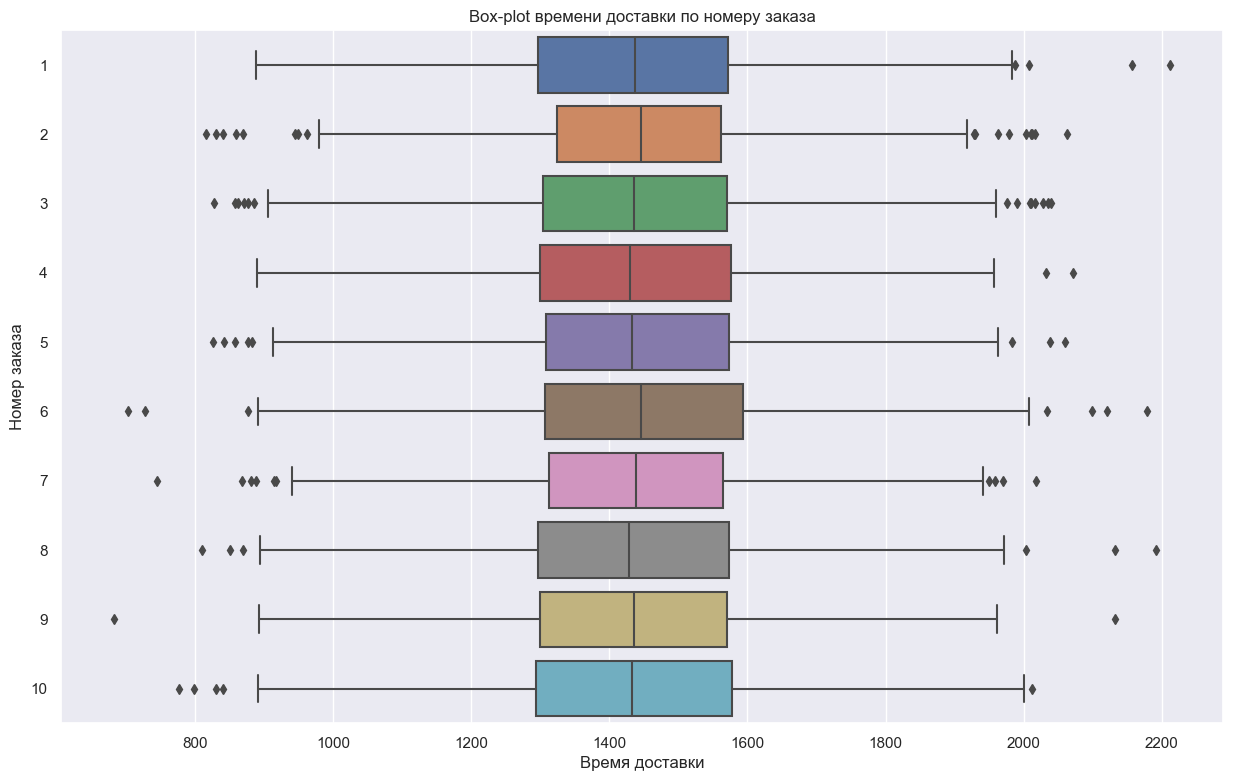

In [731]:
sns.set(rc={'figure.figsize':(15,9)})

ax = sns.boxplot(x="delivery_time", y="order_num", data=df, orient="h")
plt.xlabel('Время доставки'), plt.ylabel('Номер заказа'), plt.title('Box-plot времени доставки по номеру заказа');

**Комментарий:**

Для полного описания данных идеально подходит "ящик с усами" по группам. Из него мы можем увидеть средние значения по группам, квартили, минимум и максимум, а также выбросы (при их наличии).
видим, что практически не отличается среднее по групам, что логично: мы брали данные по delivery_time из нормального распределения

**ЗАДАЧА 3.4**

В виде единой матрицы графиков построить графики распределения времени доставки для каждого номера заказа. Каждый отдельный график в матрице должен иметь свой цвет и на каждом из графиков максимум необходимо выделить любым цветом, отличным от основного цвета выбранного графика.


In [789]:
order_nums = df['order_num'].unique().tolist()
order_nums.sort()

##для разметки оси х
a=int(df['delivery_time'].max())
a_text=str(a)
fin_max=a+(10-int(a_text[-1]))

b=int(df['delivery_time'].max())
b_text=str(b)
fin_max=b-(int(b_text[-1]))

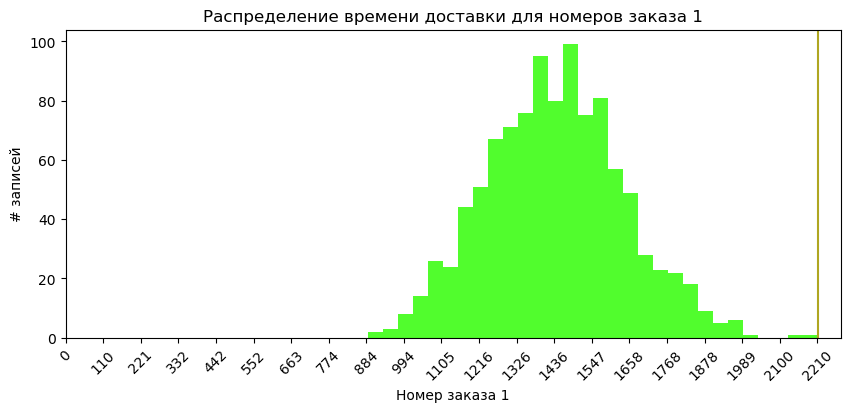

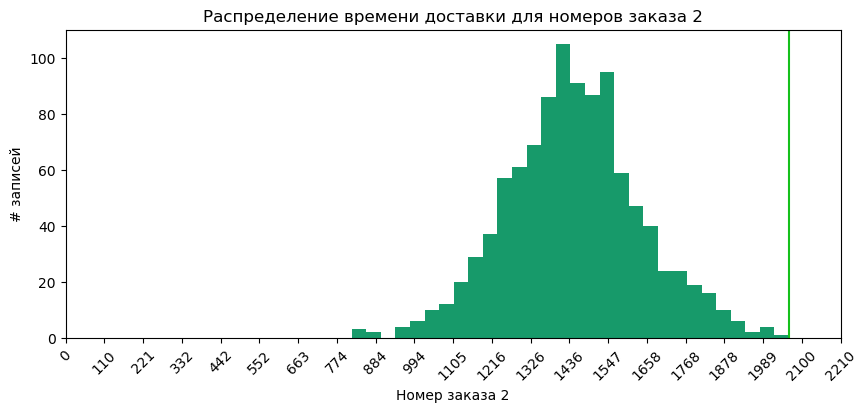

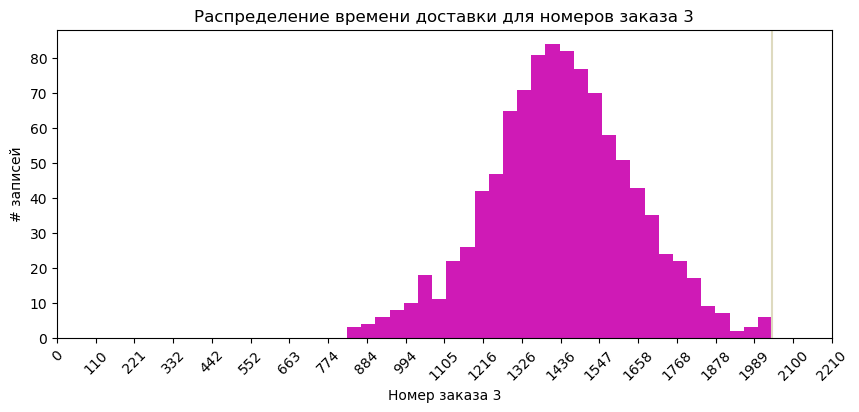

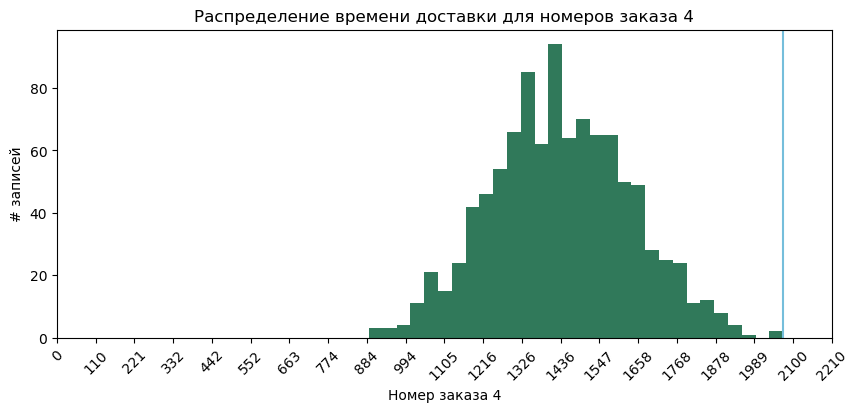

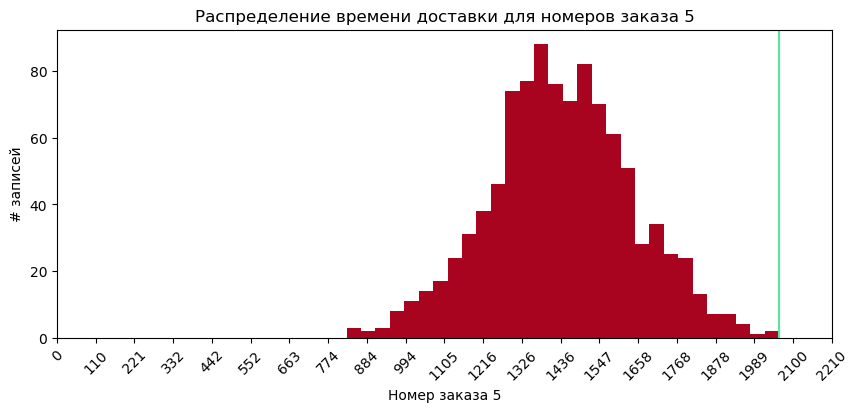

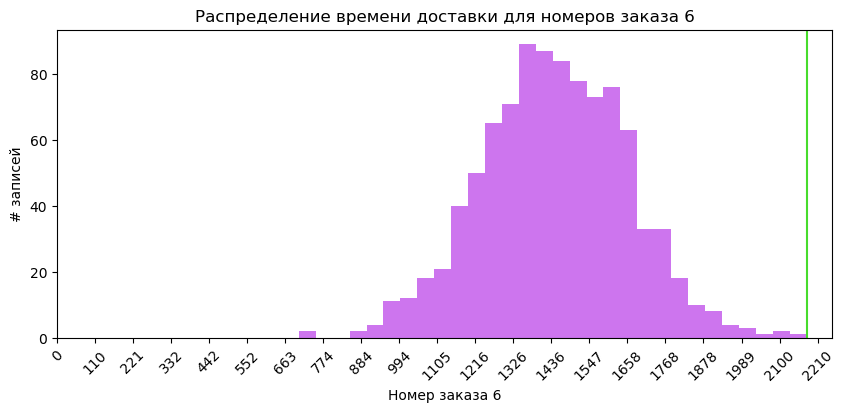

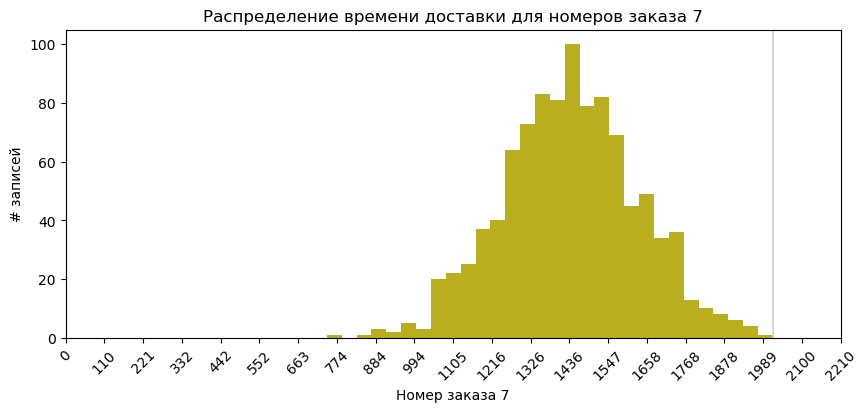

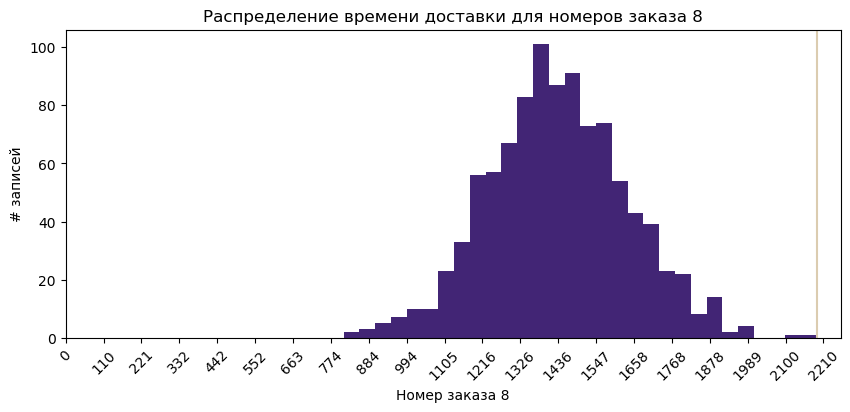

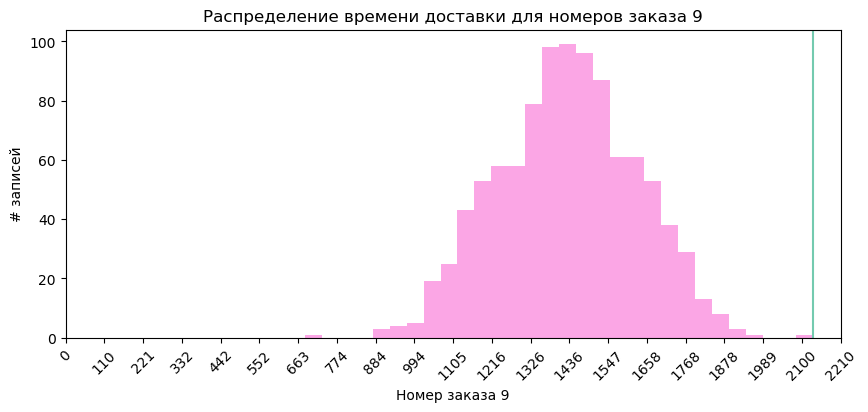

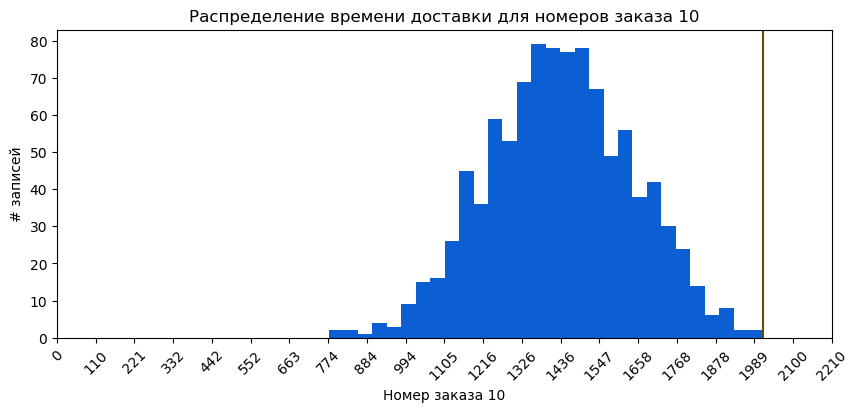

In [793]:
for i in range(len(order_nums)):
    data = df[df['order_num'] == (i+1)]['delivery_time']
    rgb = np.random.rand(3,)
    rgb2 = np.random.rand(3,)

    fig, ax = plt.subplots(figsize=(10,4), sharex = True)
    _, bins, _ = ax.hist(data, color=[rgb], bins=30)

    
    
    ax.axvline(x = max(df[df['order_num'] == (i+1)]['delivery_time']), color = rgb2) ##выделяем максимум
    ax.set_title('Распределение времени доставки для номеров заказа ' +str(i+1))
    ax.set_xlabel('Номер заказа '+str(i+1))
    ax.set_ylabel('# записей')
    
    ax.tick_params(axis = 'x', rotation = 45)
    plt.xticks(np.arange(fin_mix, fin_max, 20))
    
    ax.set_xticks(x_range)

## 4. Кластеризация   <a class="anchor" id="cluster"></a>


**ЗАДАЧА 4.1**

•	Любым удобным методом кластеризуйте пользователей, на основании переменных "время заказа" и "сумма заказа"





**Комментарии:**

Так как изначально мы генерировали данные для переменной delivery_time из нормального распределения, распределение переменной похоже на купол.
Основную дисперсию в данные вносит именно переменная delivery_time

Переменная order_cost была сформирована из экспоненциального распределения, из-за чего большинство данных смещено к единице. 

В целом кластеризовать данные по переменным, которые "разно-шкальные" не совсем верно, т.к. переменная с большей шкалой может в таком случае внести больший вклад в кластеризацию. 
По этой причине, приведем данные по переменным к одной z-шкале:


In [614]:
x = pd.DataFrame({'order_cost': (df['order_cost']-df['order_cost'].mean())/df['order_cost'].std(), 'delivery_time': (df['delivery_time']-df['delivery_time'].mean())/df['delivery_time'].std()}) 

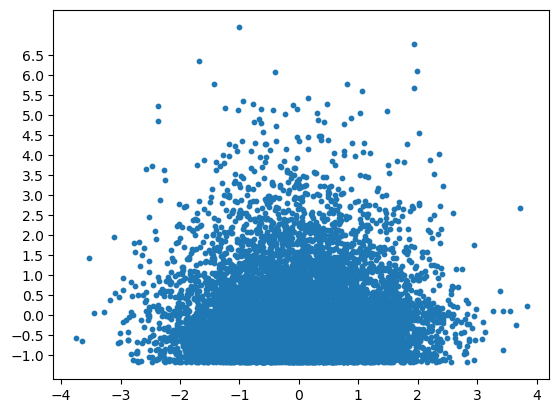

In [738]:
##для разметки оси y
a=float(int(x['order_cost'].max()))
a_text=str(a)
fin_max=int(a-int(a_text[-1]))

b=float(int(x['order_cost'].min()))
b_text=str(b)
fin_min=int(b+int(b_text[-1]))
fin_min

##график
plt.scatter( x['delivery_time'], x['order_cost'], s=10) 
plt.yticks(np.arange(fin_min, fin_max, 0.5))
plt.show()

**Комментарии:**
Мы видим, что данные по оси х похожи на нормальное Распределение, а по оси y наблюдается явное смещение. Данные достаточно однородные. По этой причине метод k-means вряд-ли даст содержательную информаю. Скорее всего этот метод просто "разрежет" наши данные случайным образом на указанное число кластеров. Но мы не поймем сколько именно кластеров нам нужно на самом деле. По этой причине лучше использовать иерархическую кластеризацию.


Кластеризация реализована в след задании, т.к. выбор числа кластеров опирается на сам процесс кластеризации

**ЗАДАЧА 4.2**

•	Обоснуйте число выбранных кластеров и присвойте их значения пользователям в отдельном столбце

**Комментарии:** 
Для начала построим дендрограмму для наших данных. Дентдрограмма позволит оценить расстояние между группами, размеры кластеров на разных уровнях агломерации

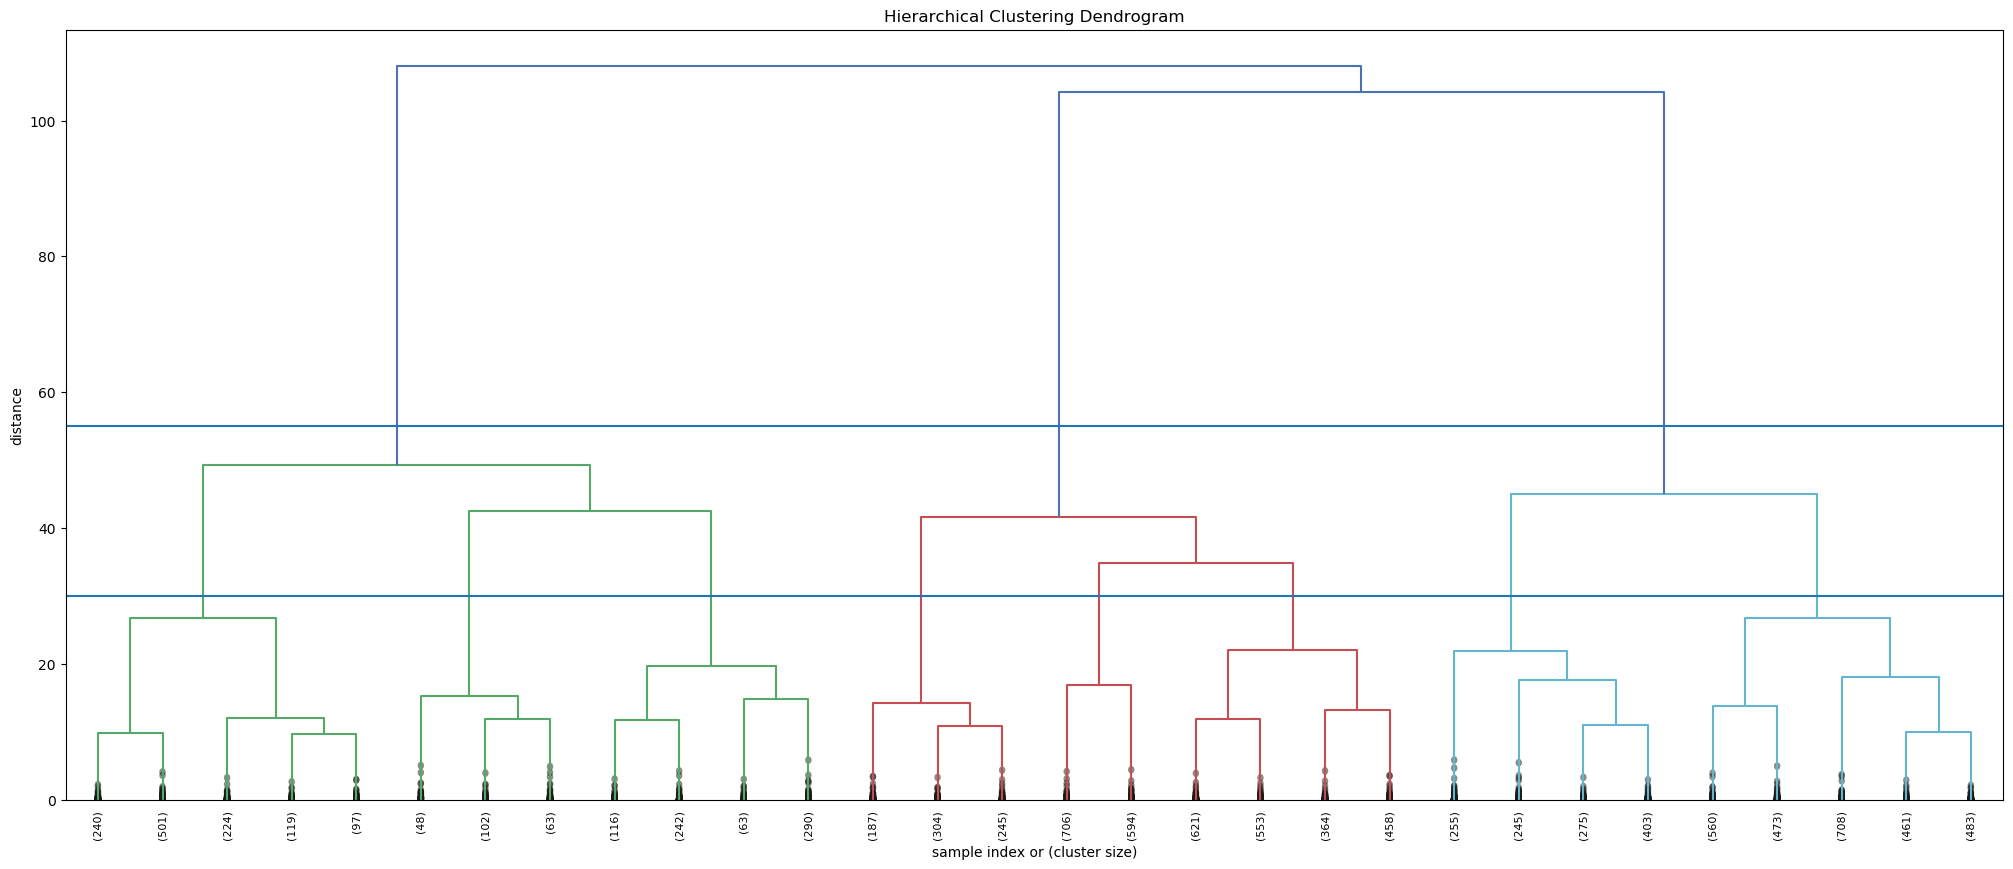

In [739]:
clusters = hierarchy.linkage(x, method="ward", metric='euclidean') ##для дендрограммы


from scipy.cluster.hierarchy import dendrogram, linkage
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    clusters,
    truncate_mode='lastp',  # show only the last p merged clusters
    ##p=12,  # show only the last p merged clusters
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    show_contracted=True,  # to get a distribution impression in truncated branches
)

plt.axhline(y=55)
plt.axhline(y=30)
plt.show()

**Комментарии:**

Кажется, что можно выделить 3-8 кластеров. Проверим скольки кластерная модель будет лучше с помощью графика каменистой осыпи (Elbow Method )

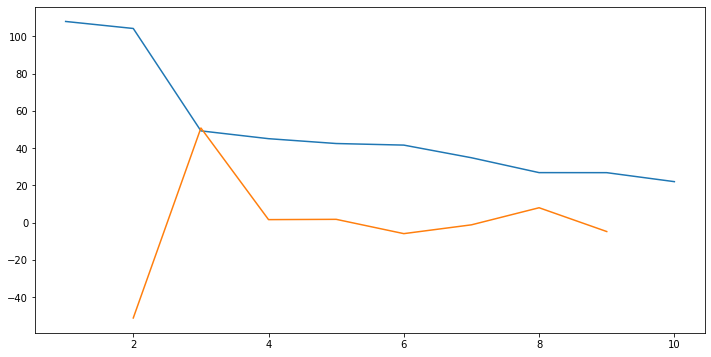

In [629]:
fig, ax = plt.subplots(figsize=(12,6))

last = clusters[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
ax.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters


**Комментарии:**
График показывает, что после 3-го кластера расстояние между кластерами становится более однородным. По этой причине остановимся на 3-ех кластерной модели


In [630]:
h_clusters=AgglomerativeClustering(n_clusters=3, affinity='euclidean',linkage='ward').fit_predict(x)
h_clusters

## добавляем кластеры в базу
df['claster']=h_clusters


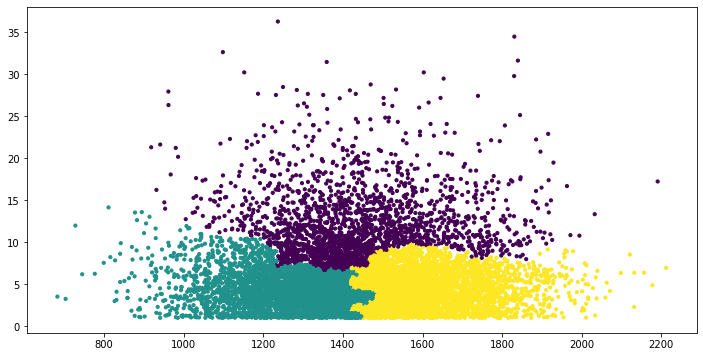

In [633]:
## Посмотрим как распределились наши кластеры уже на ненормированных(исходных) данных
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(df['delivery_time'], df['order_cost'], s=10, c=df['claster']) 
plt.show() 

## 5. AB-тест   <a class="anchor" id="ab-test"></a>



•	Выберите два любых кластера пользователей и проведите их сравнение


In [634]:
###Посмотрим на кластерные центры
df.groupby('claster').agg({'delivery_time': ['mean'], 'order_cost': ['mean']} ).reset_index()

,delivery_time,order_cost
,mean,mean
claster,,
0,1435.730214,12.158475
1,1268.990588,4.112881
2,1603.473847,4.433693


**Комментарии:**

Сравним нулевой и первый кластеры. Учитывая особенность распределения данных, они должны отличаться больше всего. 

Для сравнения используем гистограмму для основных метрических переменных: order_cost, delivery_time

Сравним кластеры по второй переменной: сумма заказа

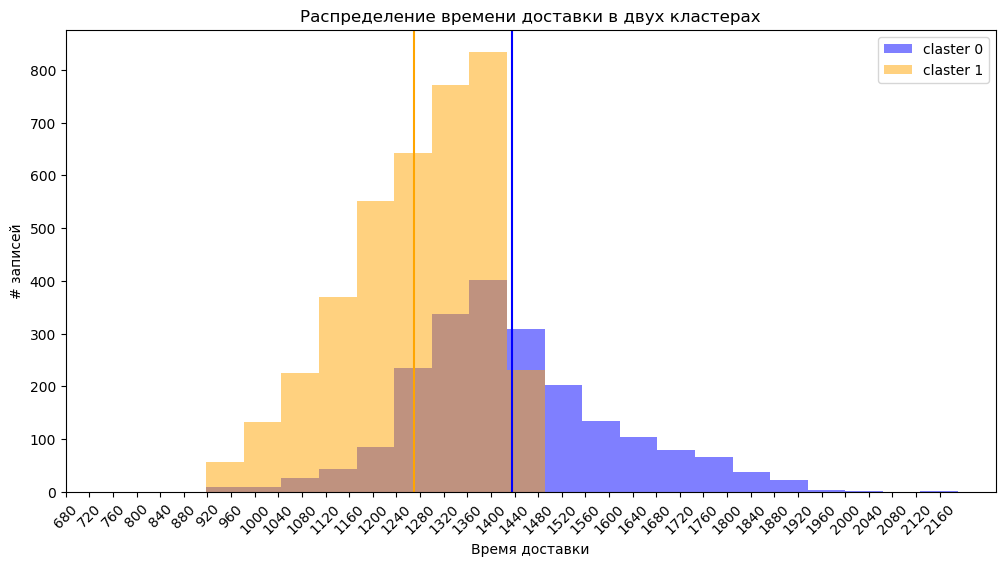

In [772]:
d_del0 = df[df['claster'] == 0]['delivery_time']
d_del1  = df[df['claster'] == 1]['delivery_time']

##для разметки оси x
comp_max=int(max(d_del0.max(), d_del1.max()))
comp_text_max=str(comp_max)
fin_comp_max=int(comp_max+(10-int(comp_text_max[-1])))

comp_min=int(min(d_del0.min(), d_del1.min()))
comp_text=str(comp_min)
fin_comp_mix=int(comp_min-int(comp_text[-1]))

fig, ax = plt.subplots(figsize=(12,6))
_, bins, _ = ax.hist(d_del0, label = 'claster 0', alpha = 0.5, bins = 20, color = 'blue')
ax.hist(d_del1, label = 'claster 1', alpha = 0.5, bins = bins, color = 'orange')

ax.axvline(x = df[df['claster'] == 0]['delivery_time'].mean(), color = 'blue') ##выделяем среднее
ax.axvline(x = df[df['claster'] == 1]['delivery_time'].mean(), color = 'orange') ##выделяем среднее

ax.set_title('Распределение времени доставки в двух кластерах')
ax.set_xlabel('Время доставки')
ax.set_ylabel('# записей')
ax.set_xticks(list(bins))
ax.tick_params(axis = 'x', rotation = 45)
ax.legend()

plt.xticks(np.arange(fin_comp_mix, fin_comp_max, 40))
plt.show()

**Комментарии:**

Как мы видим, распределения двух кластеров достаточно сильно пересекаются. Однако в кластере 0 дисперсия данных значительно выше, а сами данные распределены "почти" нормальным образом. 
В кластере 1 наблюдается большая однородность данных. При этом, само распределение скошено в сторону большего времени доставки. 

Проверим с помощью z-теста отличаются ли выделенные кластеры по времени доставки. Для этого сформулируем гипотезы:

- H0 (нулевая гипотеза): средние значения в группах одинаковые;
- H1 (альтернативная гипотеза):  средние значения в группах отличаются.

В качестве критического значения возьмем стандартные 5%

In [684]:
# задаем уровень значимости
alpha = 0.05

#проводим тест
z_stat, p_value = ztest(d_del0, d_del1, value=0, alternative='two-sided') 
print('p-value: {:.5f}'.format(p_value))

# анализируем результат
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: доля целевых наблюдений не равна заданному порогу.')
else:
    print('Не отвергаем нулевую гипотезу: доля целевых наблюдений равна заданному порогу.')

p-value: 0.00000
Отвергаем нулевую гипотезу: доля целевых наблюдений не равна заданному порогу.


**Комментарии:**

На основе z-теста можем сделать вывод, что сегменты отличаются по среднему времени доставки. 


In [751]:
comp_min=int(min(o_cost0.min(), o_cost1.min()))
comp_text=str(comp_min)
fin_comp_mix=int(comp_min-int(comp_text[-1]))


Теперь посмотрим отличаются ли группы по сумме заказа

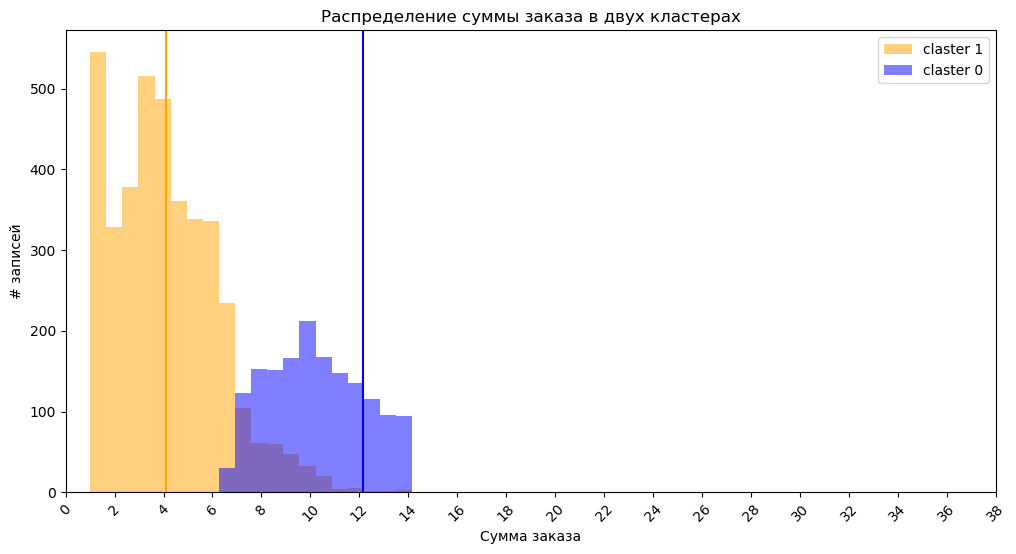

In [770]:
o_cost0 = df[df['claster'] == 0]['order_cost']
o_cost1  = df[df['claster'] == 1]['order_cost']

##для разметки оси x
comp_max=int(max(o_cost0.max(), o_cost1.max()))
comp_text_max=str(comp_max)
fin_comp_max=int(comp_max+(10-int(comp_text_max[-1])))

comp_min=int(min(o_cost0.min(), o_cost1.min()))
comp_text=str(comp_min)
fin_comp_mix=int(comp_min-int(comp_text[-1]))

fig, ax = plt.subplots(figsize=(12,6))
_, bins, _ = ax.hist(o_cost1, label = 'claster 1', alpha = 0.5, bins = 20, color = 'orange')
ax.hist(o_cost0, label = 'claster 0', alpha = 0.5, bins = bins, color = 'blue')


ax.axvline(x = df[df['claster'] == 0]['order_cost'].mean(), color = 'blue') ##выделяем среднее
ax.axvline(x = df[df['claster'] == 1]['order_cost'].mean(), color = 'orange') ##выделяем среднее

ax.set_title('Распределение суммы заказа в двух кластерах')
ax.set_xlabel('Сумма заказа')
ax.set_ylabel('# записей')
ax.set_xticks(list(bins))
ax.tick_params(axis = 'x', rotation = 45)
ax.legend()

plt.xticks(np.arange(0, fin_comp_max, 2))
plt.show()

**Комментарии:**

Как мы видим, кластеры имеют площадь пересечения. Однако в целом средние достаточно удалены друг от друга, что позволяет предположить, что кластеры отличаются по сумме заказа

Проверим с помощью z-теста отличаются ли выделенные кластеры по сумме заказа. Для этого сформулируем гипотезы:

- H0 (нулевая гипотеза): средние значения в группах одинаковые;
- H1 (альтернативная гипотеза):  средние значения в группах отличаются.

В качестве критического значения возьмем стандартные 5%

In [722]:
# задаем уровень значимости
alpha = 0.05

#проводим тест
z_stat, p_value = ztest(o_cost0, o_cost1, value=0, alternative='two-sided') 
print('p-value: {:.5f}'.format(p_value))

# анализируем результат
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: доля целевых наблюдений не равна заданному порогу.')
else:
    print('Не отвергаем нулевую гипотезу: доля целевых наблюдений равна заданному порогу.')

p-value: 0.00000
Отвергаем нулевую гипотезу: доля целевых наблюдений не равна заданному порогу.


**Комментарии:**

На основе z-теста можем сделать вывод, что сегменты отличаются по среднему времени доставки. 
